# Image Processing Project 

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dctn, idctn
import os
import PIL 
from PIL import Image
import pandas as pd

## Helper Functions

### DCT & IDCT 

In [9]:
def dct2(f, m):
    return dctn(f, norm='ortho')[:m, :m]
def idct2(f):
    return idctn(f, norm='ortho')

### Compression

In [10]:
def compress_DCT(component, m):
    h, w = component.shape
    h_pad = (h + 7) // 8 * 8
    w_pad = (w + 7) // 8 * 8
    padded = np.pad(component, ((0, h_pad - h), (0, w_pad - w)), mode='constant')

    patch_size = 8
    dct_blocks = np.zeros_like(padded)
    for i in range(0, h_pad, patch_size):
        for j in range(0, w_pad, patch_size):
            dct_blocks[i:(i + m), j:(j + m)] = dct2(padded[i:(i + patch_size), j:(j + patch_size)], m)

    return dct_blocks[:h, :w]

### Decompression

In [11]:
def decompress_DCT(compressed, m):
    h, w = compressed.shape
    decompressed = np.zeros((h, w))

    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = compressed[i:i + 8, j:j + 8]
            decompressed[i:i + 8, j:j + 8] = idct2(block)

    return decompressed

### Calculate PNSR

In [12]:
def calculate_PSNR(original, decompressed):
    mse = np.mean((original - decompressed) ** 2)
    peak = 255  # Peak value for uint8 image
    psnr = 10 * np.log10((peak ** 2) / mse)
    return psnr

## Main Function

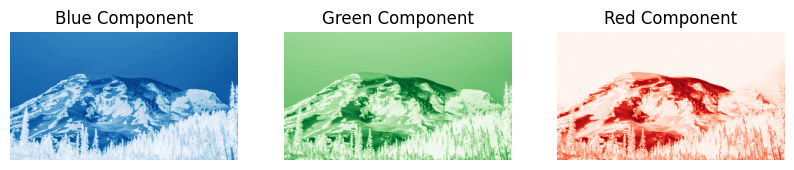

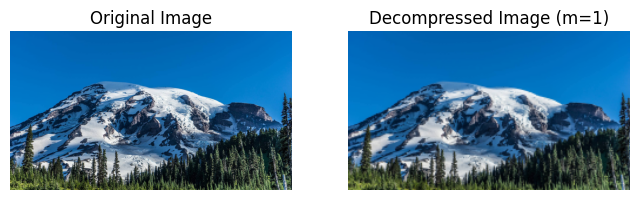

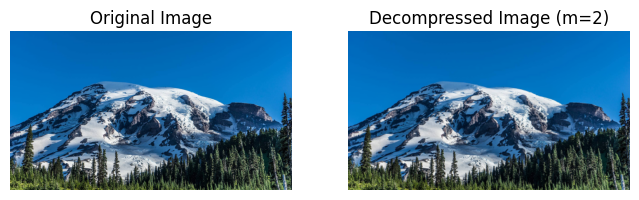

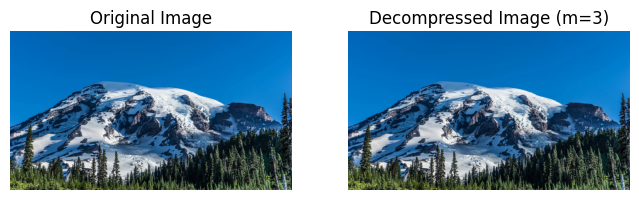

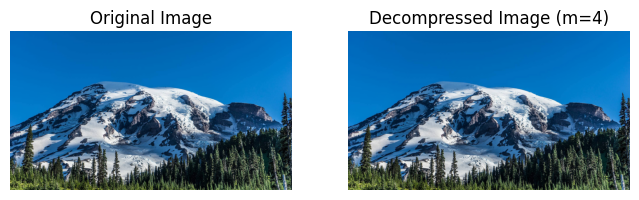

In [13]:
# Read the input image and extract color components
image = cv2.imread('pictures/original_image.png')
b, g, r = cv2.split(image)
# original_image_path
original_image_path = 'image1.png'
# Display individual color components
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(b, cmap='Blues')
plt.title('Blue Component')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(g, cmap='Greens')
plt.title('Green Component')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(r, cmap='Reds')
plt.title('Red Component')
plt.axis('off')
plt.savefig('pictures/image_components.png')
plt.show()
# Plot PSNR against m
psnr_values = []
m_values = [1, 2, 3, 4]
for m in m_values:
    compressed_r = compress_DCT(r.astype(np.float64), m)
    compressed_g = compress_DCT(g.astype(np.float64), m)
    compressed_b = compress_DCT(b.astype(np.float64), m)

    compressed_image = cv2.merge([compressed_b, compressed_g, compressed_r])
    cv2.imwrite(f'pictures/compressed_images/compressed_image_m{m}.png', compressed_image)
    
    decompressed_r = decompress_DCT(compressed_r, m)
    decompressed_g = decompress_DCT(compressed_g, m)
    decompressed_b = decompress_DCT(compressed_b, m)

    decompressed_image = cv2.merge([decompressed_b, decompressed_g, decompressed_r])
    
    psnr = calculate_PSNR(image.astype(np.float64), decompressed_image)
    psnr_values.append(psnr)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    decompressed_image = np.clip(decompressed_image, 0, 255).astype(np.uint8)
    plt.imshow(cv2.cvtColor(decompressed_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Decompressed Image (m={m})')
    plt.axis('off')
    plt.savefig(f'pictures/compare_results/Original_Decompressed (m={m}).png')
    # decompressed_image.save(f'Decompressed Image (m={m})')
    cv2.imwrite(f'pictures/decompressed_images/decompressed_image_m{m}.png', decompressed_image)
    plt.show()


### Compare Size 

<Figure size 800x600 with 0 Axes>

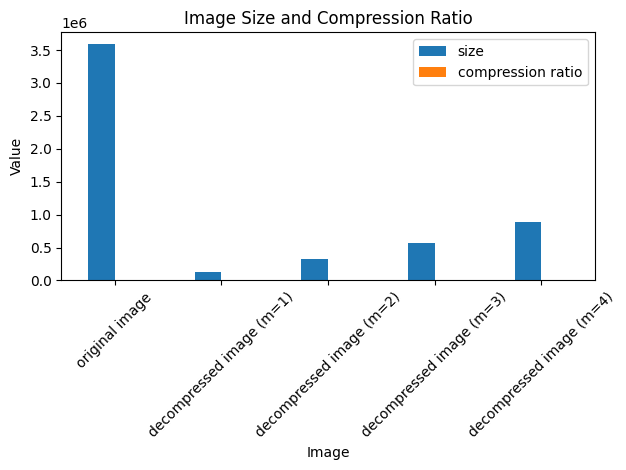

In [14]:
original_size = os.path.getsize('pictures/original_image.png')
image_size = []
image_compression_ratio = []
image_size.append(original_size)
image_compression_ratio.append(1)
for i in range(1, 5, 1):
    compressed_image_path = f'pictures/compressed_images/compressed_image_m{i}.png'
    compressed_size = os.path.getsize(compressed_image_path)
    compression_ratio = original_size / compressed_size
    image_size.append(compressed_size)
    image_compression_ratio.append(compression_ratio)
    

data = {
    'size': image_size,
    'compression ratio': image_compression_ratio
}
df = pd.DataFrame.from_dict(data)
df.index=["original image", "decompressed image (m=1)", "decompressed image (m=2)", "decompressed image (m=3)", "decompressed image (m=4)"]
# df.head()

# Plot DataFrame
plt.figure(figsize=(8, 6))
df.plot(kind='bar', rot=45)
plt.title('Image Size and Compression Ratio')
plt.xlabel('Image')
plt.ylabel('Value')
plt.tight_layout()

# Save plot as PNG image
plt.savefig('pictures/compression_sizes.png')

# Show plot (optional)
plt.show()

### Plot PNSR

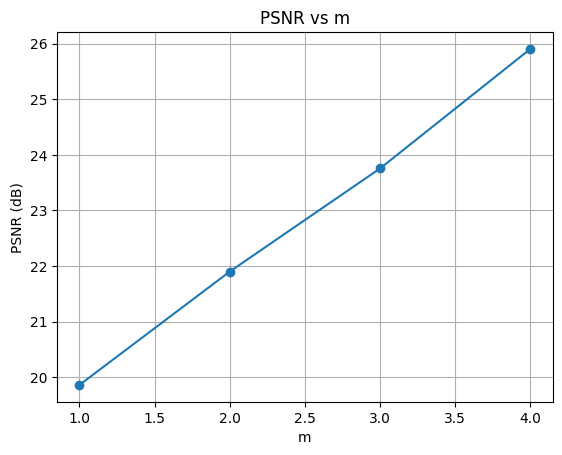

In [16]:
plt.plot(m_values, psnr_values, marker='o')
plt.title('PSNR vs m')
plt.xlabel('m')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.savefig('pictures/PNSR.png')
plt.show()

### Link to The project pdf  [here](https://drive.google.com/drive/folders/1L8eS0gcDDs7jQJ8kjgJQtqpeWrygsE3j)